In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [9]:
data_path_CMU = 'data/CMU/'
NAMES_MOVIES = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
NAMES_CHARACTER = ['Character_Name','Actor_DOB','Actor_gender','Actor_height','Actor_ethnicity','Actor_Name','Actor_age_at_movie_release','Freebase_character_actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']

df_CMU_character = pd.read_csv(data_path_CMU+'character.metadata.tsv', sep='\t', names = NAMES_CHARACTER, header = None)
df_CMU_movies = pd.read_csv(data_path_CMU+'movie.metadata.tsv', sep='\t', names = NAMES_MOVIES, header = None)


In [18]:
#Oui c'est dégeulasse mais j'avais pas le temps de le faire plus proprement
df_CMU_character["Freebase_movie_ID"] = 0
Freebase_movie_ID = []
for i in range(len(df_CMU_character)):
    Freebase_movie_ID.append(df_CMU_character.index[i][1])
df_CMU_character["Freebase_movie_ID"] = Freebase_movie_ID

In [20]:
grouped_actors = df_CMU_character.groupby('Freebase_movie_ID').agg({
    'Actor_Name': list,
    'Freebase_actor_ID': list
}).reset_index()
# Merge the grouped actors data with the movies data
movies_with_actors = df_CMU_movies.merge(grouped_actors, on='Freebase_movie_ID', how='left')

# Rename columns as needed
movies_with_actors.rename(columns={'Actor_name': 'Actors', 'Actor_ID': 'Actor_IDs'}, inplace=True)

In [70]:
movies_with_actors = movies_with_actors.dropna(subset=['Actor_Name'])

In [82]:
played_together = nx.Graph()

for _, row in movies_with_actors.iterrows():
    actors = row['Actor_Name']
    for i in range(len(actors)):
        for j in range(i + 1, len(actors)):
            if actors[j]!=actors[i]:
                played_together.add_edge(actors[i], actors[j], film=row['Movie_name'])

nan_nodes = [node for node in played_together.nodes if pd.isna(node)] 
played_together.remove_nodes_from(nan_nodes)

In [120]:
high_degree_nodes = [node for node, degree in played_together.degree() if degree > 1000]

subgraph = played_together.subgraph(high_degree_nodes)

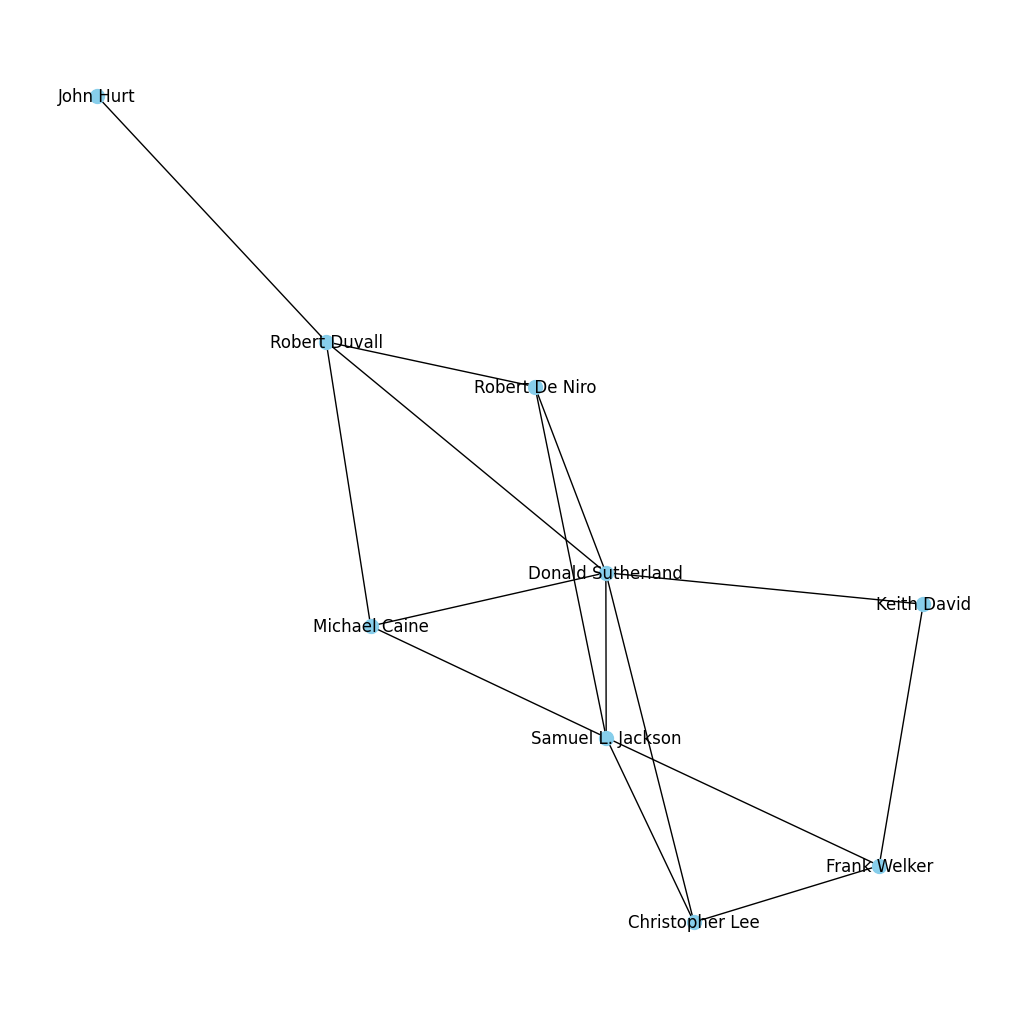

In [124]:
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=True, node_size=100, node_color="skyblue")
plt.show()

In [126]:
print(dict(nx.degree_centrality(subgraph)))

{'Christopher Lee': 0.375, 'Robert De Niro': 0.375, 'Samuel L. Jackson': 0.625, 'Keith David': 0.25, 'Frank Welker': 0.375, 'Donald Sutherland': 0.75, 'Michael Caine': 0.375, 'John Hurt': 0.125, 'Robert Duvall': 0.5}
